In [7]:
from transformers import BertTokenizer, BertModel, pipeline, AutoConfig, AutoModel, AutoModelForMaskedLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch_datasets import *

In [4]:
# MODEL_PATH = '../logs/1l1h_top_two_max_len_3_range_64/trained'
MODEL_PATH = '../logs/3l1h_top_2_max_len_5_range_64/trained'
USE_DATASET_GENERATION = True
# DATA_PATH = '../data/top_two_max_len_3_range_64_val.csv'

## Load Model

In [5]:
# Load pre-trained model and tokenizer
model = AutoModelForMaskedLM.from_pretrained(MODEL_PATH, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

## Get Attention Weights

In [8]:
texts = []
if USE_DATASET_GENERATION:
    # Generate dataset
    df = TopKDataset(9, 5, 2, 64, random_seed=42).data
else:
    # read in the csv file from DATA_PATH
    df = pd.read_csv(DATA_PATH)
# get the first 9 row of the dataframe
for i in range(9):
    texts.append(df.iloc[i]['text'])

# texts[0] = "29 9 62 [SEP] [MASK] [MASK]"

inputs = tokenizer(texts, return_tensors='pt')

# Get model outputs for the 9 samples
outputs = model(**inputs)
attention = outputs.attentions  # Get attention weights
# decode the output
decoded = []
for i in range(9):
    decoded.append(tokenizer.decode(outputs.logits[i].argmax(dim=-1).squeeze().tolist()[-3:-1]))
# decoded = tokenizer.decode(outputs.logits.argmax(dim=-1).squeeze().tolist())

## Check Information

In [9]:
# print(attention)
# print shape of attention
# print([a.shape for a in attention])
print(model)
print(type(attention))
print(len(attention))
print(type(attention[0]))
print(attention[0].shape)

# for i, a in enumerate(attention):
#     print(i)
#     print(a)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-2): 3 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

## Visualization
- Visualize attention for the first layer, first head (which is the only attention map for 1l1h model)
- The first dimension of an attention map (y-axis) corresponds to "query" and the second dimension (x-axis) corresponds to "key"

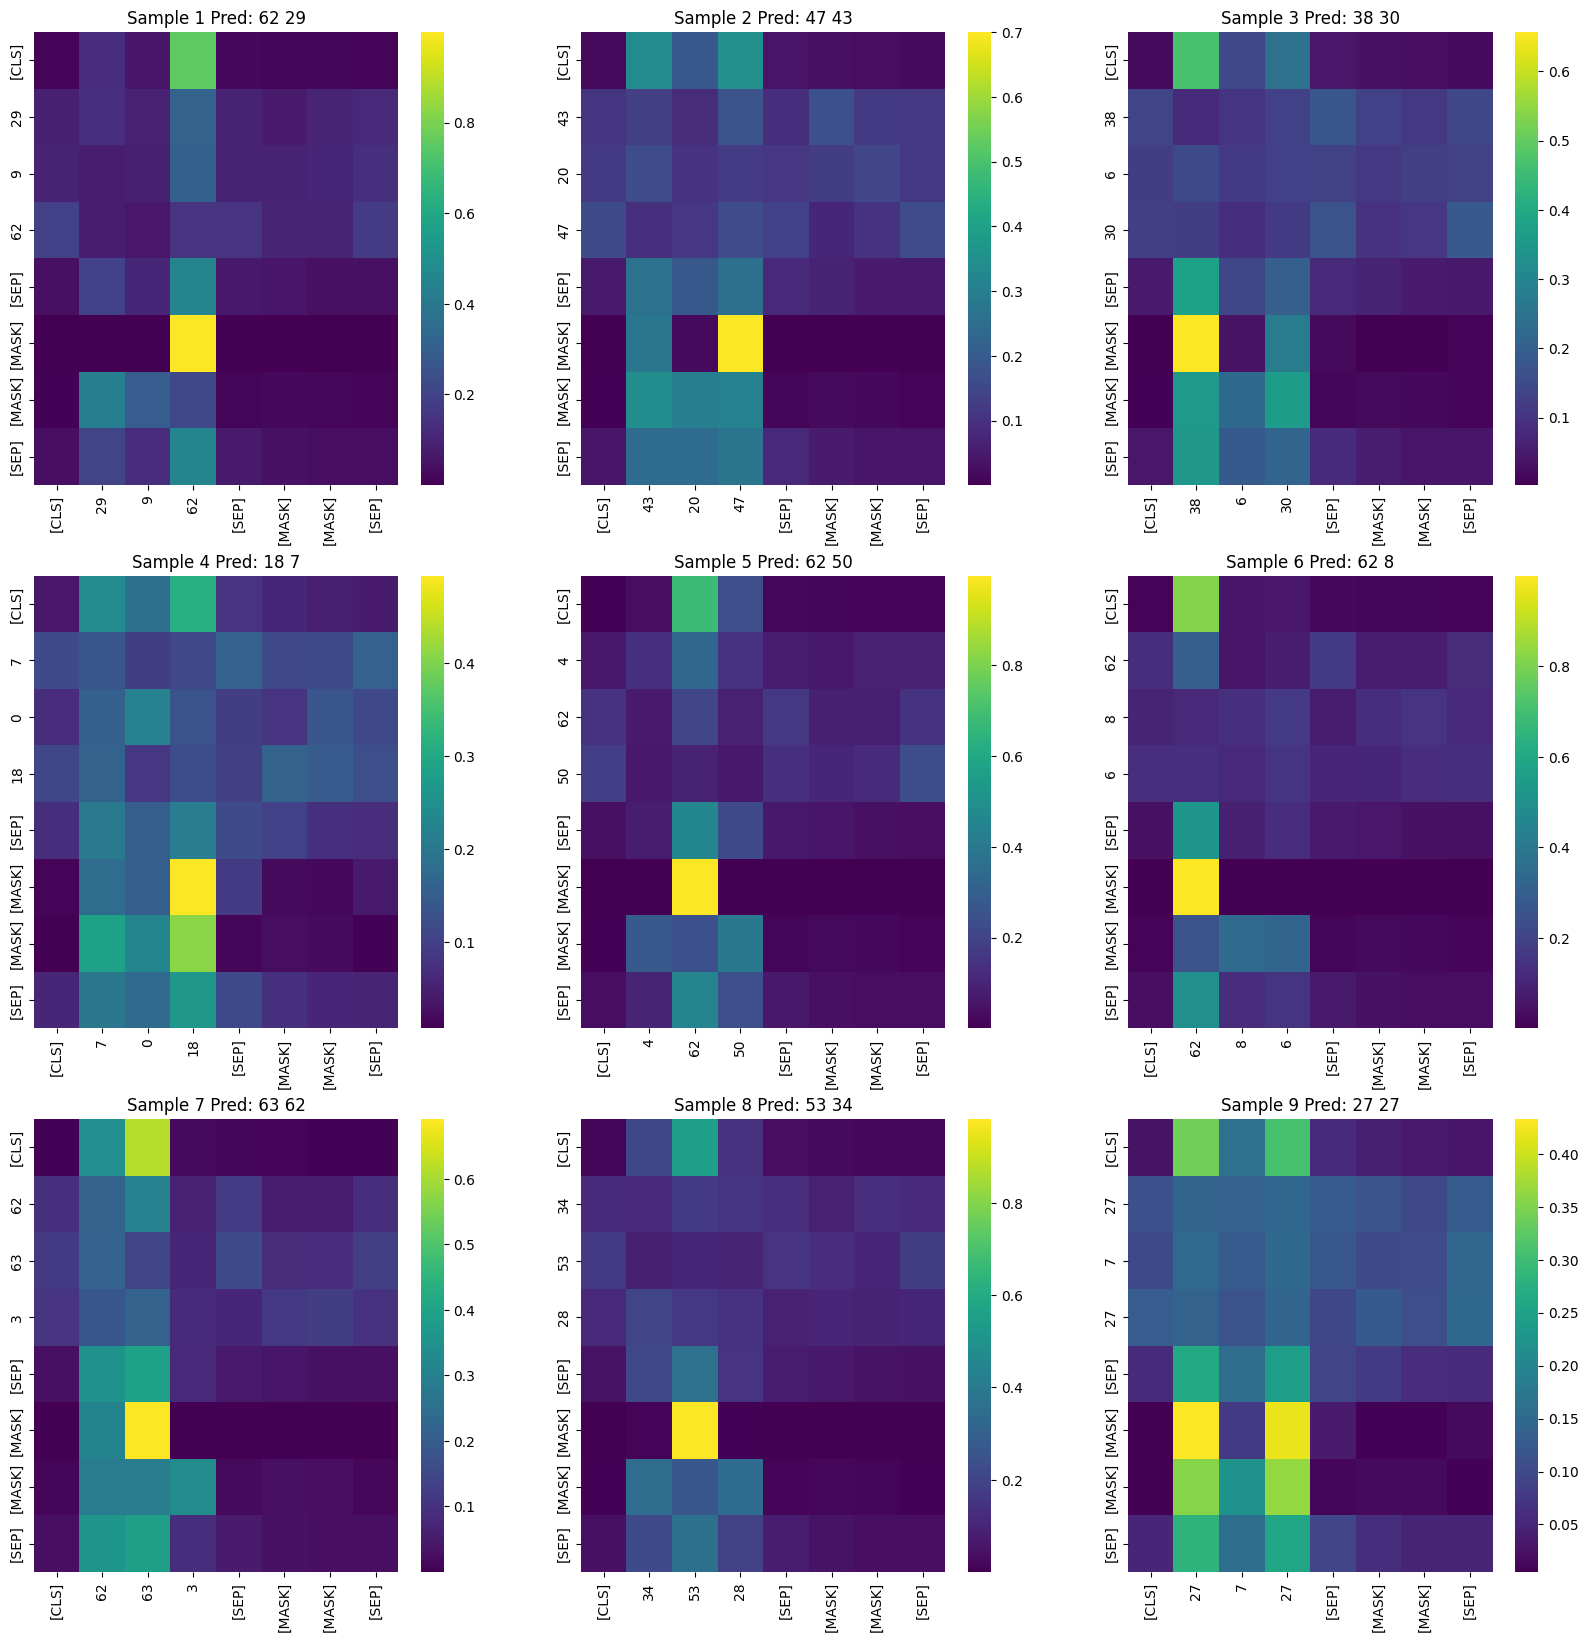

In [6]:
# Convert attention tensor to numpy
# attn = attention[0][0][0].detach().numpy()
attn = []
for i in range(9):
    attn.append(attention[0][i][0].detach().numpy())



# Plot heatmap as 9 subplots for the 9 samples
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
for i in range(9):
    sns.heatmap(attn[i], xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][i]), cmap='viridis', ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'Sample {i+1} Pred: {decoded[i]}')
plt.show()


# sns.heatmap(attn, xticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), yticklabels=tokenizer.convert_ids_to_tokens(inputs['input_ids'][0]), cmap='viridis')
# plt.show()